## Common Utilities (Run it first)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
import warnings
import re
from gensim.models import TfidfModel
import gensim.corpora
from gensim.corpora import Dictionary
warnings.filterwarnings('ignore')


CATEGORIES = ['hate_speech', 'offensive_language', 'neither']
CLASS_LABELS = {
    0: 'hate_speech',
    1: 'offensive_language',
    2: 'neither'
}

def download_nltk_data():
    """Download necessary NLTK models."""
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
    return set(stopwords.words('english'))

def clean_text(text):
    """Clean and normalize text"""
    text = str(text).lower()

    # Remove HTML entities
    text = re.sub(r'&amp;?', 'and', text)
    text = re.sub(r'&lt;', '<', text)
    text = re.sub(r'&gt;', '>', text)
    text = re.sub(r'&#\d+;', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove user mentions (@username)
    text = re.sub(r'@\w+', '', text)

    # Remove RT indicator
    text = re.sub(r'\brt\b', '', text)

    # Remove extra whilespace
    text = ' '.join(text.split())

    return text

def get_tokens(text):
    """
    Tokenize text into words
    """
    tokens = word_tokenize(text)
    # Keep only alphabetic tokens (remove punctuation, numbers, emoji)
    tokens = [token for token in tokens if token.isalpha() and len(token) > 1]

    return tokens

def count_pronouns(tokens):
    """
    Count pronouns in a list of tokens using POS tagging
    """
    if not tokens:
        return 0
    pos_tags = nltk.pos_tag(tokens)
    
    # Count personal pronouns (PRP) and possessive pronouns (PRP$)
    pronoun_count = sum([1 for word, tag in pos_tags if tag in ['PRP', 'PRP$']])

    return pronoun_count 

def load_and_explore_data(filepath):
    """Load data, print initial exploration, and return DataFrame."""
    print("--- 1. Data Loading and Exploration ---")
    df = pd.read_csv(filepath)
    print(f"Dataset shape: {df.shape}")
    print(f"\nColumns: {df.columns.tolist()}")
    print(f"\nData types:\n{df.dtypes}")
    print(f"\nMissing values:\n{df.isnull().sum()}")
    print(f"\nClass distribution:\n{df['class'].value_counts()}")
    return df

def preprocess_data(df, stop_words):
    """Apply all preprocessing steps to the dataframe."""
    print("\n--- 2. Data Preprocessing ---")
    df['category'] = df['class'].map(CLASS_LABELS)
    print("✓ Added 'category' column.")

    print("Cleaning text...")
    df['cleaned_tweet'] = df['tweet'].apply(clean_text)
    print("✓ Cleaned tweets.")

    print("Tokenizing text...")
    df['tokens'] = df['cleaned_tweet'].apply(get_tokens)
    df['tokens_no_stop'] = df['tokens'].apply(lambda tokens: [t for t in tokens if t not in stop_words])
    print("✓ Tokenized tweets and removed stopwords.")

    print("Counting pronouns...")
    df['pronoun_count'] = df['tokens'].apply(count_pronouns)
    print("✓ Counted pronouns.")
    
    return df


## Task 1: Hate Speech Statistics and Word Cloud 

### Task 1.1: Hate Speech Statistics and Top Frequent Terms

--- 1. Data Loading and Exploration ---
Dataset shape: (24783, 7)

Columns: ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet']

Data types:
Unnamed: 0             int64
count                  int64
hate_speech            int64
offensive_language     int64
neither                int64
class                  int64
tweet                 object
dtype: object

Missing values:
Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

Class distribution:
class
1    19190
2     4163
0     1430
Name: count, dtype: int64

--- 2. Data Preprocessing ---
✓ Added 'category' column.
Cleaning text...
✓ Cleaned tweets.
Tokenizing text...
✓ Tokenized tweets and removed stopwords.
Counting pronouns...
✓ Counted pronouns.

--- 3. Vocabulary and Statistical Analysis ---
Processing: Hate Speech
Number of tweets: 1430
Processing: Offensive Language

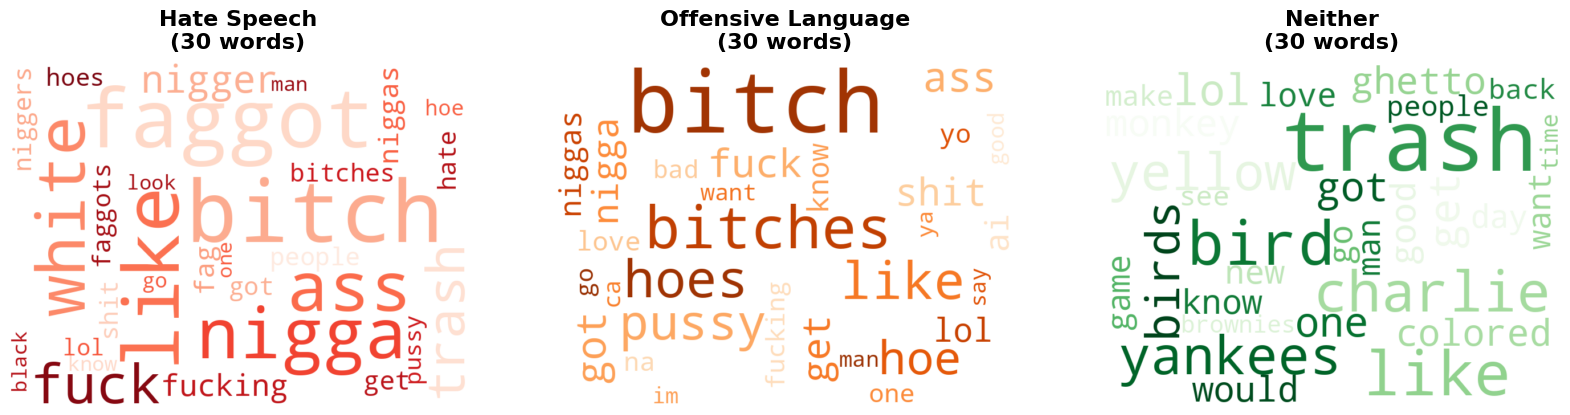

In [ ]:
def calculate_vocabulary_stats(df):
    """Calculate vocabulary and token statistics for each category."""
    print("\n--- 3. Vocabulary and Statistical Analysis ---")
    results = {}
    
    for category in CATEGORIES:
        print(f"Processing: {category.replace('_', ' ').title()}")

        # Filter tweets for this category
        category_df = df[df['category'] == category]
        print(f"Number of tweets: {len(category_df)}")
        all_tokens = []
        pronoun_counts = []
        token_counts = []

        all_tokens = [token for token_list in category_df['tokens'] for token in token_list]
        token_counts = category_df['tokens'].apply(len)
        pronoun_counts = category_df['pronoun_count']
            
        vocabulary = set(all_tokens)
        vocabulary_size = len(vocabulary)
        total_tokens = len(all_tokens)

        avg_tokens = np.mean(token_counts)
        std_tokens = np.std(token_counts)

        avg_pronouns = np.mean(pronoun_counts)
        std_pronouns = np.std(pronoun_counts)

        tokens_no_stop = [token for token_list in category_df['tokens_no_stop'] for token in token_list]

        word_freq = Counter(tokens_no_stop)
        most_common_30 = word_freq.most_common(30)

        results[category] = {
            'vocabulary_size': vocabulary_size,
            'total_tokens': total_tokens,
            'avg_tokens_per_post': avg_tokens,
            'std_tokens_per_post': std_tokens,
            'avg_pronouns_per_post': avg_pronouns,
            'std_pronouns_per_post': std_pronouns,
            'top_30_words': most_common_30,
            'num_posts': len(category_df)
        }
    return results

def print_stats_summary_table(results):
    """Prints a formatted summary table of the vocabulary statistics."""
    print("\n" + "="*80)
    print("Vocabulary and Statistical Analysis Summary")
    print("="*80)
    summary_data = []
    for category in CATEGORIES:
        stats = results[category]
        summary_data.append({
            'Category': category.replace("_", " ").title(),
            'Num Tweets': stats['num_posts'],
            'Vocabulary Size': stats['vocabulary_size'],
            'Total Tokens': stats['total_tokens'],
            'Avg Tokens/Post': stats['avg_tokens_per_post'],
            'Std Tokens/Post': stats['std_tokens_per_post'],
            'Avg Pronouns/Post': stats['avg_pronouns_per_post'],
            'Std Pronouns/Post': stats['std_pronouns_per_post'] 
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))

def plot_statistical_summary(results):
    """Creates and shows a 2x2 plot of vocabulary statistics."""
    print("\nGenerating statistical plots...")
    sns.set_style('whitegrid')
    fig, axes = plt.subplots(2, 2, figsize=(15,10))
    fig.suptitle("Vocabulary and Linguistic Analysis by Category", fontsize=16, fontweight='bold')

    # Prepare data
    categories_display = [cat.replace('_', ' ').title() for cat in CATEGORIES]

    ax1 = axes[0, 0]
    vocabs_size = [results[category]['vocabulary_size'] for category in CATEGORIES]
    bars1 = ax1.bar(categories_display, vocabs_size, color=['#e74c3c', '#f39c12', '#27ae60'], edgecolor='black', linewidth=1.5)
    ax1.set_title('Vocabulary Size by Category', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Vocabulary Size', fontsize=12)
    ax1.tick_params(axis='x', rotation=15)
    ax1.grid(axis='y', alpha=0.3)

    for bar in bars1: 
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2., height, f'{int(height):,}', ha='center', va='bottom', fontsize=10)
    
    
    ax2= axes[0, 1]
    avg_tokens = [results[category]['avg_tokens_per_post'] for category in CATEGORIES]
    std_tokens = [results[cateogry]['std_tokens_per_post'] for cateogry in CATEGORIES]
    bars2 = ax2.bar(categories_display, avg_tokens, yerr=std_tokens, color=['#e74c3c', '#f39c12', '#27ae60'], edgecolor='black', linewidth=1.5, capsize=5)
    ax2.set_title("Average Tokens Per Tweet", fontsize=14, fontweight='bold')
    ax2.set_ylabel("Number of Tokens", fontsize=12)
    ax2.tick_params(axis='x', rotation=15)
    ax2.grid(axis='y', alpha=0.3)

    ax3 = axes[1, 0]
    avg_pronouns = [results[cat]['avg_pronouns_per_post'] for cat in CATEGORIES]
    std_pronouns = [results[cat]['std_pronouns_per_post'] for cat in CATEGORIES]
    bars3 = ax3.bar(categories_display, avg_pronouns, yerr=std_pronouns,
                color=['#e74c3c', '#f39c12', '#27ae60'], 
                edgecolor='black', linewidth=1.5, capsize=5)
    ax3.set_title('Average Pronouns per Tweet', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Number of Pronouns', fontsize=12)
    ax3.tick_params(axis='x', rotation=15)
    ax3.grid(axis='y', alpha=0.3)

    # Type-Token Ratio
    ax4 = axes[1,1]
    ttr = [results[cat]['vocabulary_size'] / results[cat]['total_tokens'] for cat in CATEGORIES]
    bars4 = ax4.bar(categories_display, ttr, color=['#e74c3c', '#f39c12', '#27ae60'], edgecolor='black', linewidth=1.5)
    ax4.set_title('Type-Token Ratio (Lexical Diversity)', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Ratio (Vocabulary / Tokens)', fontsize=12)
    ax4.tick_params(axis='x', rotation=15)
    ax4.grid(axis='y', alpha=0.3)

    for bar in bars4:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=10)
        
    plt.tight_layout()
    plt.show()

def analyze_category_balance(results):
    """Analyzes and prints the balance of tweet categories in the dataset."""
    print("\n" + "=" * 80)
    print("Category Balance Analysis")
    print("="*80)

    category_counts = {}
    for category in CATEGORIES: 
        category_counts[category] = results[category]['num_posts']
    
    total_tweets = sum(category_counts.values())

    print(f"\nTotal tweets in dataset: {total_tweets:,}")
    for category in CATEGORIES:
        count = category_counts[category]
        percentage = (count / total_tweets) * 100
        cat_display = category.replace('_', ' ').title()

        # Visual bar
        bar_length = int(percentage / 2)
        bar = '█' * bar_length
        print(f"{cat_display:<20s}: {count:6,} tweets ({percentage:5.2f}%) {bar}")


    counts = list(category_counts.values())
    max_count = max(counts)
    min_count = min(counts)
    imbalance_ratio = max_count / min_count

    print("\n" + "-" * 60)
    print(f"Balance Metrics: ")
    print(f"  Largest category: {max(category_counts, key=category_counts.get).replace('_', ' ').title()}")
    print(f"                     {max_count:,} tweets ({max_count/total_tweets*100:.1f}%)")
    print(f"  Smallest category: {min(category_counts, key=category_counts.get).replace('_', ' ').title()}")
    print(f"                     {min_count:,} tweets ({min_count/total_tweets*100:.1f}%)")
    print(f"  Imbalance ratio:   {imbalance_ratio:.2f}:1")

    # Calculate std
    count_std = np.std(counts)
    count_mean = np.mean(counts)
    count_cv = (count_std / count_mean) * 100

    print(f"\nStatistical Balance Metrics:")
    print(f"  Mean tweets/category:      {count_mean:.0f}")
    print(f"  Standard deviation:        {count_std:.0f}")
    print(f"  Coefficient of variation:  {count_cv:.2f}%")

    print(f"\n📊 Balance Interpretation:")
    if imbalance_ratio < 1.5:
        print("  ✓ WELL-BALANCED dataset")
        print("    → All categories have similar sample sizes")
        print("    → No special handling needed for classification")
    elif imbalance_ratio < 3.0:
        print("  ️  MODERATELY IMBALANCED dataset")
        print("    → Some categories are underrepresented")
        print("    → Recommend: Use stratified splitting and class weights")
    elif imbalance_ratio < 10.0:
        print("  ️  HIGHLY IMBALANCED dataset")
        print("    → Significant class imbalance detected")
        print("    → Recommend: SMOTE, class weights, or balanced sampling")
    else:
        print("   SEVERELY IMBALANCED dataset")
        print("    → Extreme class imbalance")
        print("    → Critical: Advanced balancing techniques required")


def get_top_frequent_words(df, stop_words, n=30):
    top_30_words = {}
    print("\nExtracting top {n} frequent words per category...")

    for category in CATEGORIES:
        # Get all tokens for this category (already computed earlier)
        # But we need to recompute with top 30
        category_df = df[df['category'] == category]
        
        all_tokens = []
        for tweet in category_df['tweet']:
            cleaned = clean_text(tweet)
            tokens = get_tokens(cleaned)
            all_tokens.extend(tokens)
        
        # Remove stopwords
        tokens_no_stop = [token for token in all_tokens if token not in stop_words]
        
        # Get top 30
        word_freq = Counter(tokens_no_stop)
        top_30 = word_freq.most_common(30)
        
        top_30_words[category] = {
            'words_list': [word for word, count in top_30],
            'words_set': set([word for word, count in top_30]),
            'words_freq': dict(top_30)
        }
        
        cat_display = category.replace('_', ' ').title()
        print(f"  ✓ {cat_display}: {len(top_30)} words extracted")
    return top_30_words




def display_top_words(top_30_words):
    """Displays the top 30 most frequent words for each category."""
    print("\n" + "="*60)
    print("Top 30 Most Frequent Tokens for Each Category")
    print("="*60) 

    for category in CATEGORIES:
        cat_display = category.replace("_", ' ').title()
        print(f"\n{cat_display}:")
        print("-"*60)

        words_list = top_30_words[category]['words_list']
        for i in range(0, 30, 3):
            row = []
            for j in range(3):
                if i + j < len(words_list):
                    word = words_list[i + j]
                    count = top_30_words[category]['words_freq'][word]
                    row.append(f"{i+j+1:2d}. {word:15s} ({count:5,})")
            print(" ".join(row))


def analyze_vocabulary_overlap(top_30_words):
    """Calculates and interprets the Jaccard similarity of top words between categories."""
    overlap_matrix = {}
    for category in CATEGORIES:
        overlap_matrix[category] = {}

    print("\nJaccard Similarity (Intersection / Union)")
    print("-"*70)
    for i, cat1 in enumerate(CATEGORIES):
        for cat2 in CATEGORIES[i+1:]:
            set1 = top_30_words[cat1]['words_set']
            set2 = top_30_words[cat2]['words_set']

            # Calculate overlap
            intersection = set1 & set2
            union = set1 | set2


            jaccard = len(intersection) / len(union) if len(union) > 0 else 0

            overlap_count = len(intersection)
            overlap_pct = (overlap_count / 30) * 100

            overlap_matrix[cat1][cat2] = overlap_count
            overlap_matrix[cat2][cat1] = overlap_count

            cat1_display = cat1.replace("_"," ").title()
            cat2_display = cat2.replace("_", " ").title()

            print(f"\n{cat1_display} ↔ {cat2_display}:")
            print(f"  Common words: {overlap_count}/30 ({overlap_pct:.1f}%)")
            print(f"  Jaccard similarity: {jaccard:.3f}")

            if intersection:
                common_sorted = sorted(intersection)
                print(f"  Shared words: {', '.join(common_sorted)}")
            else: 
                print("Shared common word: None")
    
    all_overlap = []
    for i, cat1 in enumerate(CATEGORIES):
        for cat2 in CATEGORIES[i+1:]:
            overlap_count = overlap_matrix[cat1][cat2]
            all_overlap.append(overlap_count)

    avg_overlap = np.mean(all_overlap)
    std_overlap = np.std(all_overlap)
    max_overlap = max(all_overlap)
    min_overlap = min(all_overlap)


    print("\n" + "="*70)
    print("Overall Overlap Statistics:")
    print(f"  Average overlap:        {avg_overlap:.1f} words ({avg_overlap/30*100:.1f}%)")
    print(f"  Standard deviation:     {std_overlap:.1f} words")
    print(f"  Maximum overlap:        {max_overlap} words ({max_overlap/30*100:.1f}%)")
    print(f"  Minimum overlap:        {min_overlap} words ({min_overlap/30*100:.1f}%)")


    print(f"\nOverlap Interpretation:")
    if avg_overlap < 5:
        print("  ✓ LOW overlap - Categories have DISTINCT vocabularies")
        print("    → Words are highly specific to each category")
        print("    → Excellent for vocabulary-based classification")
    elif avg_overlap < 10:
        print("    MODERATE overlap - Some shared vocabulary")
        print("    → Categories share some common words")
        print("    → Good separation but with some overlap")
    elif avg_overlap < 15:
        print("    HIGH overlap - Significant vocabulary sharing")
        print("    → Many words appear across categories")
        print("    → May need context-based features, not just word frequency")
    else:
        print("  VERY HIGH overlap - Categories use similar vocabulary")
        print("    → Extensive word sharing across categories")
        print("    → Word frequency alone may not distinguish categories well")






stop_words = download_nltk_data()

df = load_and_explore_data('reddit_hate_speech.csv')
df = preprocess_data(df, stop_words)

# Calculate and display the stats
vocabulary_stats = calculate_vocabulary_stats(df)
print_stats_summary_table(vocabulary_stats)

# Analyze vocabulary balance and vocabulary
analyze_category_balance(vocabulary_stats)
top_30_words = get_top_frequent_words(df, stop_words, n=30)
display_top_words(top_30_words)
analyze_vocabulary_overlap(top_30_words)


### Task 1.2: Generate Word Cloud for Top 30 Frequent Words for Each Category

Generating wordcloud for category: Hate Speech
Generating wordcloud for category: Offensive Language
Generating wordcloud for category: Neither


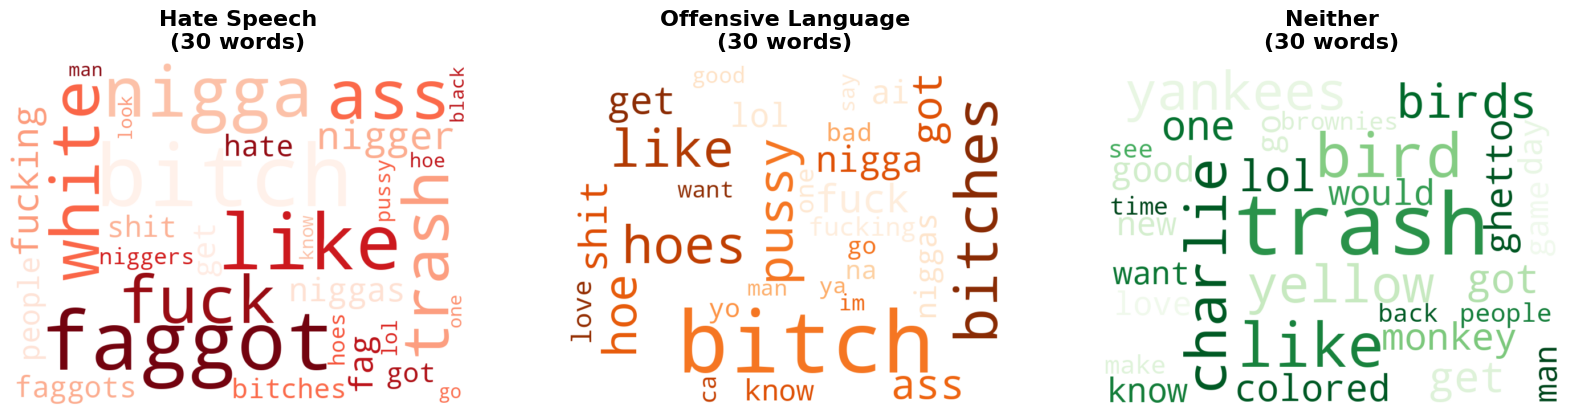

In [6]:
def generate_wordclouds(top_30_words):
    color_schemes = {
        'hate_speech': 'Reds',
        'offensive_language': 'Oranges',
        'neither': 'Greens'
    }

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    for idx, category in enumerate(CATEGORIES):
        print(f"Generating wordcloud for category: {category.replace("_", " ").title()}")


        word_freq = top_30_words[category]['words_freq'] 
        

        # Create word cloud
        wordcloud = WordCloud(
            width=800,
            height=600,
            background_color='white',
            colormap=color_schemes[category],
            relative_scaling=0.5,
            min_font_size=10,
            max_font_size=150,
            prefer_horizontal=0.7,
            collocations=False
        ).generate_from_frequencies(word_freq)
        # Plot
        ax = axes[idx]
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')

        cat_display = category.replace("_", " ").title()
        ax.set_title(f'{cat_display}\n({len(word_freq)} words)', fontsize=16, fontweight='bold', pad=10)

    plt.show()


generate_wordclouds(top_30_words)

## Task 2: TF-IDF and Most Relevant Tokens for Each Category

In [7]:
def tf_idf_category_relevant_tokens_analysis(df, top_30_words_by_freq):
    """Performs TF-IDF analysis and compares results with frequency-based rankings."""
    print("\n--- 4. TF-IDF Category-Relevant Token Analysis ---")
    category_documents = {} # Treating each category as one document

    for cat in CATEGORIES:
        print(f"Processing category: {cat.replace("_", " ").title()}")
        category_df = df[df['category'] == cat]
        tokens_no_stops = [token for token_list in category_df['tokens_no_stop'] for token in token_list]
        category_documents[cat] = tokens_no_stops

        print(f"  Total tokens (no stop words): {len(tokens_no_stops):,}")
        print(f"  Unique tokens: {len(set(tokens_no_stops)):,}")
    

    # Build gensim dictionary and corpus
    print("\n" + "-"*80)
    print("Build Gensim Dictionary and Corpus")

    documents = [category_documents[cat] for cat in CATEGORIES]

    # Use the Dictionary class imported from gensim.corpora to create the dictionary
    dictionary = Dictionary(documents)

    print(f"\nDictionary created: ")
    print(f"    Total unique tokens in all categories: {len(dictionary)}")
    print(f"    Token IDs range: 0 to {len(dictionary) - 1}")


    corpus = [dictionary.doc2bow(doc) for doc in documents]
    print(f"Corpus created")
    print(f"    Number of documents: {len(corpus)}")
    for idx, cat in enumerate(CATEGORIES):
        print(f"    {cat.replace("_"," ").title()}: {len(corpus[idx])} unique tokens")

    print("\n" + "-"*80)
    print("Compute TF-IDF scores")
    print("-"*80)


    # Train TF-IDF model (pass corpus so idfs are computed)
    tfidf_model = TfidfModel(corpus)
    # Applies tf-idf transformation; this returns a TransformedCorpus wrapper
    corpus_tfidf = tfidf_model[corpus]

    print("\nTF-IDF trained succesfully")
    print("Computing tf-idf csores for each category")
    tfidf_score_by_category = {}
    for idx, category in enumerate(CATEGORIES):
        tfidf_vector = corpus_tfidf[idx]

        # Convert to dictionary: {token_id: tfidf_score}
        tfidf_dict = dict(tfidf_vector)

        word_scores = {}
        for token_id, score in tfidf_dict.items():
            word = dictionary[token_id]
            word_scores[word] = score

        tfidf_score_by_category[category] = word_scores
        cat_display = category.replace("_", " ").title()
        print(f"    ✓ {cat_display}: {len(word_scores)} tokens scored")



    print("\n" + "-"*80)
    print("Extracting Top 30 Tokens by TF-IDF Score")

    tfidf_top30 = {}
    for category in CATEGORIES:
        sorted_tokens = sorted(
            tfidf_score_by_category[category].items(),
            key=lambda x: x[1],
            reverse=True
        )

        top_30 = sorted_tokens[:30]

        tfidf_top30[category] = {
            'words_list': [word for word, score in top_30],
            'words_set': set([word for word, score in top_30]),
            'scores_dict': dict(top_30)
        }

        cat_display = category.replace("_", " ").title()
        print(f"\n{cat_display} - Top 30 by TF-IDF:")
        print("-"*60)


        for rank, (word, score) in enumerate(top_30, 1):
            print(f"    {rank:2d}. {word:20s} (TF-IDF: {score:.4f})")
    
    print("\n" + "="*80)
    print("Compare TF-IDF vs Frequency Rankings")
    print("="*80)


    overlap_analysis = {}
    for category in CATEGORIES:
        freq_set = top_30_words_by_freq[category]['words_set']
        tfidf_set = tfidf_top30[category]['words_set']

        intersection = freq_set & tfidf_set
        only_in_freq = freq_set - tfidf_set
        only_in_tfidf = tfidf_set - freq_set

        overlap_count = len(intersection)
        overlap_pct = (overlap_count / 30) * 100


        overlap_analysis[category] = {
            'intersection': intersection,
            'only_in_frequency': only_in_freq,
            'only_in_tfidf': only_in_tfidf,
            'overlap_count': overlap_count,
            'overlap_percentage': overlap_pct
        }

        cat_display = category.replace("_", " ").title()

        print(f"\n{cat_display}")
        print("-"*70)
        print(f"    Overlap: {overlap_count}/30 words ({overlap_pct:.1f}%)")
        print(f"    Words in BOTH ranking: {overlap_count}")
        print(f"    Words ONLY in frequency ranking: {len(only_in_freq)}")
        print(f"    Words ONLY in TF-IDF ranking: {len(only_in_tfidf)}")

        if intersection:
            print(f"\n  Words in both ranking:")
            print(f"    {', '.join(sorted(intersection))}")
        
        if only_in_freq:
            print(f"\n  Words ONLY in frequency top-30 (not in TF-IDF top-30):")
            freq_only_list = sorted(only_in_freq)
            print(f"    {', '.join(freq_only_list)}")

        if only_in_tfidf:
            print(f"\n  Words ONLY in TF-IDF top-30 (not in frequency top-30):")
            tfidf_only_list = sorted(only_in_tfidf)
            print(f"    {', '.join(tfidf_only_list)}")


    # Calculate the avg and std for the overlap between top 30 frequent words and top 30 words with highest TF-IDF score
    print("\n" + "="*80)
    print("Overall comparison statistics")
    print("="*80)

    # Build a list of overlap counts for each category
    overlap_counts = [overlap_analysis[cat]['overlap_count'] for cat in CATEGORIES]
    avg_overlap = np.mean(overlap_counts)
    std_overlap = np.std(overlap_counts)

    print(f"\nAverage overlap (TF-IDF vs Frequency): {avg_overlap:.1f}/30 words ({avg_overlap/30*100:.1f}%)")
    print(f"Standard deviation: {std_overlap:.1f} words")

    print("\nInterpretation: ")
    if avg_overlap > 20:
        print("  ✓ HIGH overlap (>20/30)")
        print("    → TF-IDF and frequency rankings are very similar")
        print("    → Most frequent words are also most distinctive")
        print("    → Both methods identify similar important words")
    elif avg_overlap > 15:
        print("    MODERATE overlap (15-20/30)")
        print("    → Some differences between TF-IDF and frequency")
        print("    → TF-IDF captures some distinctive words missed by frequency")
        print("    → Both methods complement each other")
    elif avg_overlap > 10:
        print("    LOW overlap (10-15/30)")
        print("    → Significant differences between TF-IDF and frequency")
        print("    → TF-IDF identifies many category-specific words")
        print("    → Frequency-based ranking includes many common words")
    else:
        print("    VERY LOW overlap (<10/30)")
        print("    → TF-IDF and frequency rankings are very different")
        print("    → Frequent words are often common across categories")
        print("    → TF-IDF better captures category-distinctive vocabulary")



tf_idf_category_relevant_tokens_analysis(df, top_30_words)


--- 4. TF-IDF Category-Relevant Token Analysis ---
Processing category: Hate Speech
  Total tokens (no stop words): 10,465
  Unique tokens: 3,356
Processing category: Offensive Language
  Total tokens (no stop words): 137,096
  Unique tokens: 15,014
Processing category: Neither
  Total tokens (no stop words): 32,478
  Unique tokens: 9,201

--------------------------------------------------------------------------------
Build Gensim Dictionary and Corpus

Dictionary created: 
    Total unique tokens in all categories: 19714
    Token IDs range: 0 to 19713
Corpus created
    Number of documents: 3
    Hate Speech: 3356 unique tokens
    Offensive Language: 15014 unique tokens
    Neither: 9201 unique tokens

--------------------------------------------------------------------------------
Compute TF-IDF scores
--------------------------------------------------------------------------------

TF-IDF trained succesfully
Computing tf-idf csores for each category
    ✓ Hate Speech: 1419 token

## Task 3: Power Law Distribution Zipf's Law of Each Category

In [ ]:
def zipf_law(rank, C, alpha):
    """
    Zipf's law: frequency  = C / (rank^alpha) 

    Args:
        rank: Word rank (1, 2, 3,...)
        C: constant (normalization factor)
        alpha: Exponent (typically ~1 for natural language)
    
    Returns:
        Expected frequency
    """

    return C / (rank ** alpha)

def log_zipfs_law(log_rank, log_C, alpha):
    """
    Log-linear form of Zipf's Law: log(freq)  = log(C) - alpha * log(rank)

    Args:
        log_rank: log(rank)
        log_C: log(C)
        alpha: exponent
    
    Returns:
        log(frequency)
    """
    return log_C - alpha * log_rank

def calculate_r_squared(y_true, y_pred):
    """Calculate R^2 (coefficient of determination)"""
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

def calculate_adjusted_r_squared(r2, n, p):
    """
    Calculate adjusted R^2 

    Args:
        r2: R^2 value
        n: number of observations
        p: number of predictors (parameters - 1)
    
    Returns:
        Adjusted R^2
    """
    adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    return adj_r2
